In [1]:
!pip install matplotlib==3.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install importlib-metadata==4.13.0
!pip install dionysus
!pip install gudhi
!pip install networkx
!pip install persim
!pip install xarray
!pip install validclust
!pip install zarr
!pip install POT==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 8247
-rw------- 1 root root    1667 Oct  5 18:53  zigzagtools.py
-rw------- 1 root root   85452 Oct  5 18:53  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5 18:53  VRrips.pk
-rw------- 1 root root  133051 Oct  5 18:53  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5 18:53  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5 18:53  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5 18:53  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5 18:53  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5 18:53  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5 18:53  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5 18:53  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5 18:53  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-202102

In [5]:
from __future__ import print_function
import pickle
#import zigzagtools as zzt
import numpy as np
from numpy import linalg as LA
import pandas as pd
#import networkx as nx
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from scipy.stats import expon
import scipy
import dionysus as d
import matplotlib.pyplot as plt
import time
import netCDF4
import numpy as np
import gudhi as gd
#import networkx as nx
from persim import PersImage
import sys
import time
from validclust import dunn, cop, ValidClust
import itertools
from tqdm import tqdm
import itertools

In [6]:
import os
# added
import ot
from gudhi.wasserstein import wasserstein_distance as wd
#import regrid_hp as rhp
#import cartopy.crs as ccrs
#import healpy as hp
import xarray as xr
import mpl_toolkits
#from cartopy.io import shapereader
#from mpl_toolkits.basemap import Basemap
#import ocw.utils as utils
#import ocw.data_source.local as local
#import ocw.dataset_processor as dsp
#from ocw.dataset import Bounds as Bounds
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from persim import wasserstein
from sklearn.cluster import DBSCAN
import zarr
import seaborn as sns
sns.set_theme()

In [7]:
path = os.getcwd()
#%% Parameters 
#nameFolderCloud = path + '/PointCloud/5_Dimensions/datafullpc'  # Example 1 (Dorcas)  (sizeWindow = 10) * It has not any interesting structures
#nameFolderCloud = path + '/PointCloud/FIG8Saved_40/File'  # Example 2  (sizeWindow = 12)
#nameFolderCloud = path + '/../Example_POINT_CLOUD/PointCloud/FIG8Saved_60/File'  # Example 3  (sizeWindow = 12)
#scaleParameter = 1.0 # [Example 2 and 3] Maximum Scale Parameter for Filtration (Depends on distance between points)
#scaleParameter = 9.0 # [Example 1] Maximum Scale Parameter for Filtration (Depends on distance between points)
maxDimHoles = 2 # Maximum Dimension of Holes (It means.. 0 and 1)
sizeWindow = 28 # [Example 2 and 3] Number of Point-Clouds (i.e. timestamps) 
#sizeWindow = 10 # [Example 1] Number of Point-Clouds (i.e. timestamps) 

In [8]:
def extract_PD_arrays_with_cubical_complex(data, infinity = 300.):
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=data)
    PD_CC = cubical_complex.persistence()
    dim = np.array([i[0] for i in PD_CC])
    birth = np.array([i[1][0] for i in PD_CC])
    death = np.array([i[1][1] for i in PD_CC])
    death[death==np.Infinity] = infinity
    n0 = dim[dim==0].size
    n1 = dim[dim==1].size
    pd0 = np.zeros([n0, 2])
    pd1 = np.zeros([n1, 2])
    pd0[:,0] = birth[dim==0]
    pd0[:,1] = death[dim==0]
    pd1[:,0] = birth[dim==1]
    pd1[:,1] = death[dim==1]
    return cubical_complex, pd0, pd1

def calculate_wasserstein_distance(pd0_array1, pd0_array2, pd1_array1, pd1_array2, order=2):
    return wd(pd0_array1, pd0_array2, order=order) + wd(pd1_array1, pd1_array2, order=order)

In [9]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower =240., infinity = 300.):
    
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = infinity 
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = infinity
    
    return [[birth0,death0],[birth1,death1]]

In [10]:
def plot_PDs (pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(25,15))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][:,0], pd0_array[iday][:,1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][:,0], pd1_array[iday][:,1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        #ax.set_xlabel('Birth')
        #ax.set_ylabel('Death')
        #ax.set_xticks(np.arange(4)*20+240)
        #ax.set_xticklabels(np.repeat('',4))
        #ax.set_yticks(np.arange(4)*20+240)
        #ax.set_yticklabels(np.repeat('',4))

In [11]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    #plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()   
        

In [12]:
def plot_Dionysus_PDs_by_Cluster(pd0_array, pd1_array, titles, cluster_labels, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    idx0= np.where(cluster_labels==0)[0]
    idx1= np.where(cluster_labels==1)[0]
    
    ax = fig.add_subplot(2,2,1)
    for iday in idx0:    
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
    ax = fig.add_subplot(2,2,2)
    for iday in idx0:    
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
            facecolors='none', edgecolor='blue', label = '1')
        
    ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
    ax.set_xlim([lower_bound, upper_bound])
    ax.set_ylim([lower_bound, upper_bound])
    #ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    
    ax = fig.add_subplot(2,2,3)
    for iday in idx1:    
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
    ax = fig.add_subplot(2,2,4)
    for iday in idx1:    
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
    ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
    ax.set_xlim([lower_bound, upper_bound])
    ax.set_ylim([lower_bound, upper_bound])
    #ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')

In [13]:
def keyfunc(s):
    return s[0:5], int(s[5:7]), s[7], int(s[8:10])

def selectChannel(dir, channelNum):
    
    #tileList = [filename for filename in os.listdir(dir) if filename.startswith("Tile")]
    tempTileList = [filename for filename in os.listdir(dir) if filename.startswith("Tile")]

    print (len(tempTileList))
    tileList = []
    for i in tempTileList:
        temp = i.replace('.', '_')
        tempList = temp.split('_')
        tempList[1] = str(tempList[1].zfill(2))
        tempList[2] = str(tempList[2].zfill(2))
        result = '_'.join(tempList)
        result = result[0:10] + '.' + result[-4:]
        tileList.append(result)
    
    dict1 = dict(zip(tileList, tempTileList))
    print (dict1)
    tileList = sorted(tileList, key=keyfunc)
    print (len(tileList))
    # take first 80 tiles for test
    tileList = tileList#[0:300]
    data = np.empty((len(tileList), 32, 32))

    for i in range(len(tileList)):
        tempData = zarr.open(dir + '//' + dict1[tileList[i]])[:, :, channelNum]
        print (dict1[tileList[i]])
        data[i, :, :] = tempData

    return data

In [14]:
def getAllChannelPDs(tileName, channelRange, infinity = 300):
    PD0 = np.array([[0, 0]])
    PD1 = np.array([[0, 0]])
    for i in range(channelRange):
        data = np.array(zarr.open(fname2 + '//' + tileName)[:, :, i])
        f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
        p = d.homology_persistence(f_lower_star)
        dgms = d.init_diagrams(p, f_lower_star)
        birth0=np.array([dgm.birth for dgm in dgms[0]])
        death0=np.array([dgm.death for dgm in dgms[0]])
        death0[death0==np.Infinity] = infinity 
        birth1=np.array([dgm.birth for dgm in dgms[1]])
        death1=np.array([dgm.death for dgm in dgms[1]])
        death1[death1==np.Infinity] = infinity
        
        temp0 = np.vstack((birth0, death0)).T
        temp1 = np.vstack((birth1, death1)).T

        PD0 = np.concatenate((PD0, temp0))
        PD1 = np.concatenate((PD1, temp1))
        
    return PD0[1:, :], PD1[1:, :]

In [15]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
        
    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering  
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)   

In [16]:
def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''  
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
     for linkage in ['complete', 'average', 'single']: 
      clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
      #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          linkage_ask=linkage
          n_ask=i
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          linkage_ask=linkage
          n_ask=i 
          clustering_ask=clustering
        print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

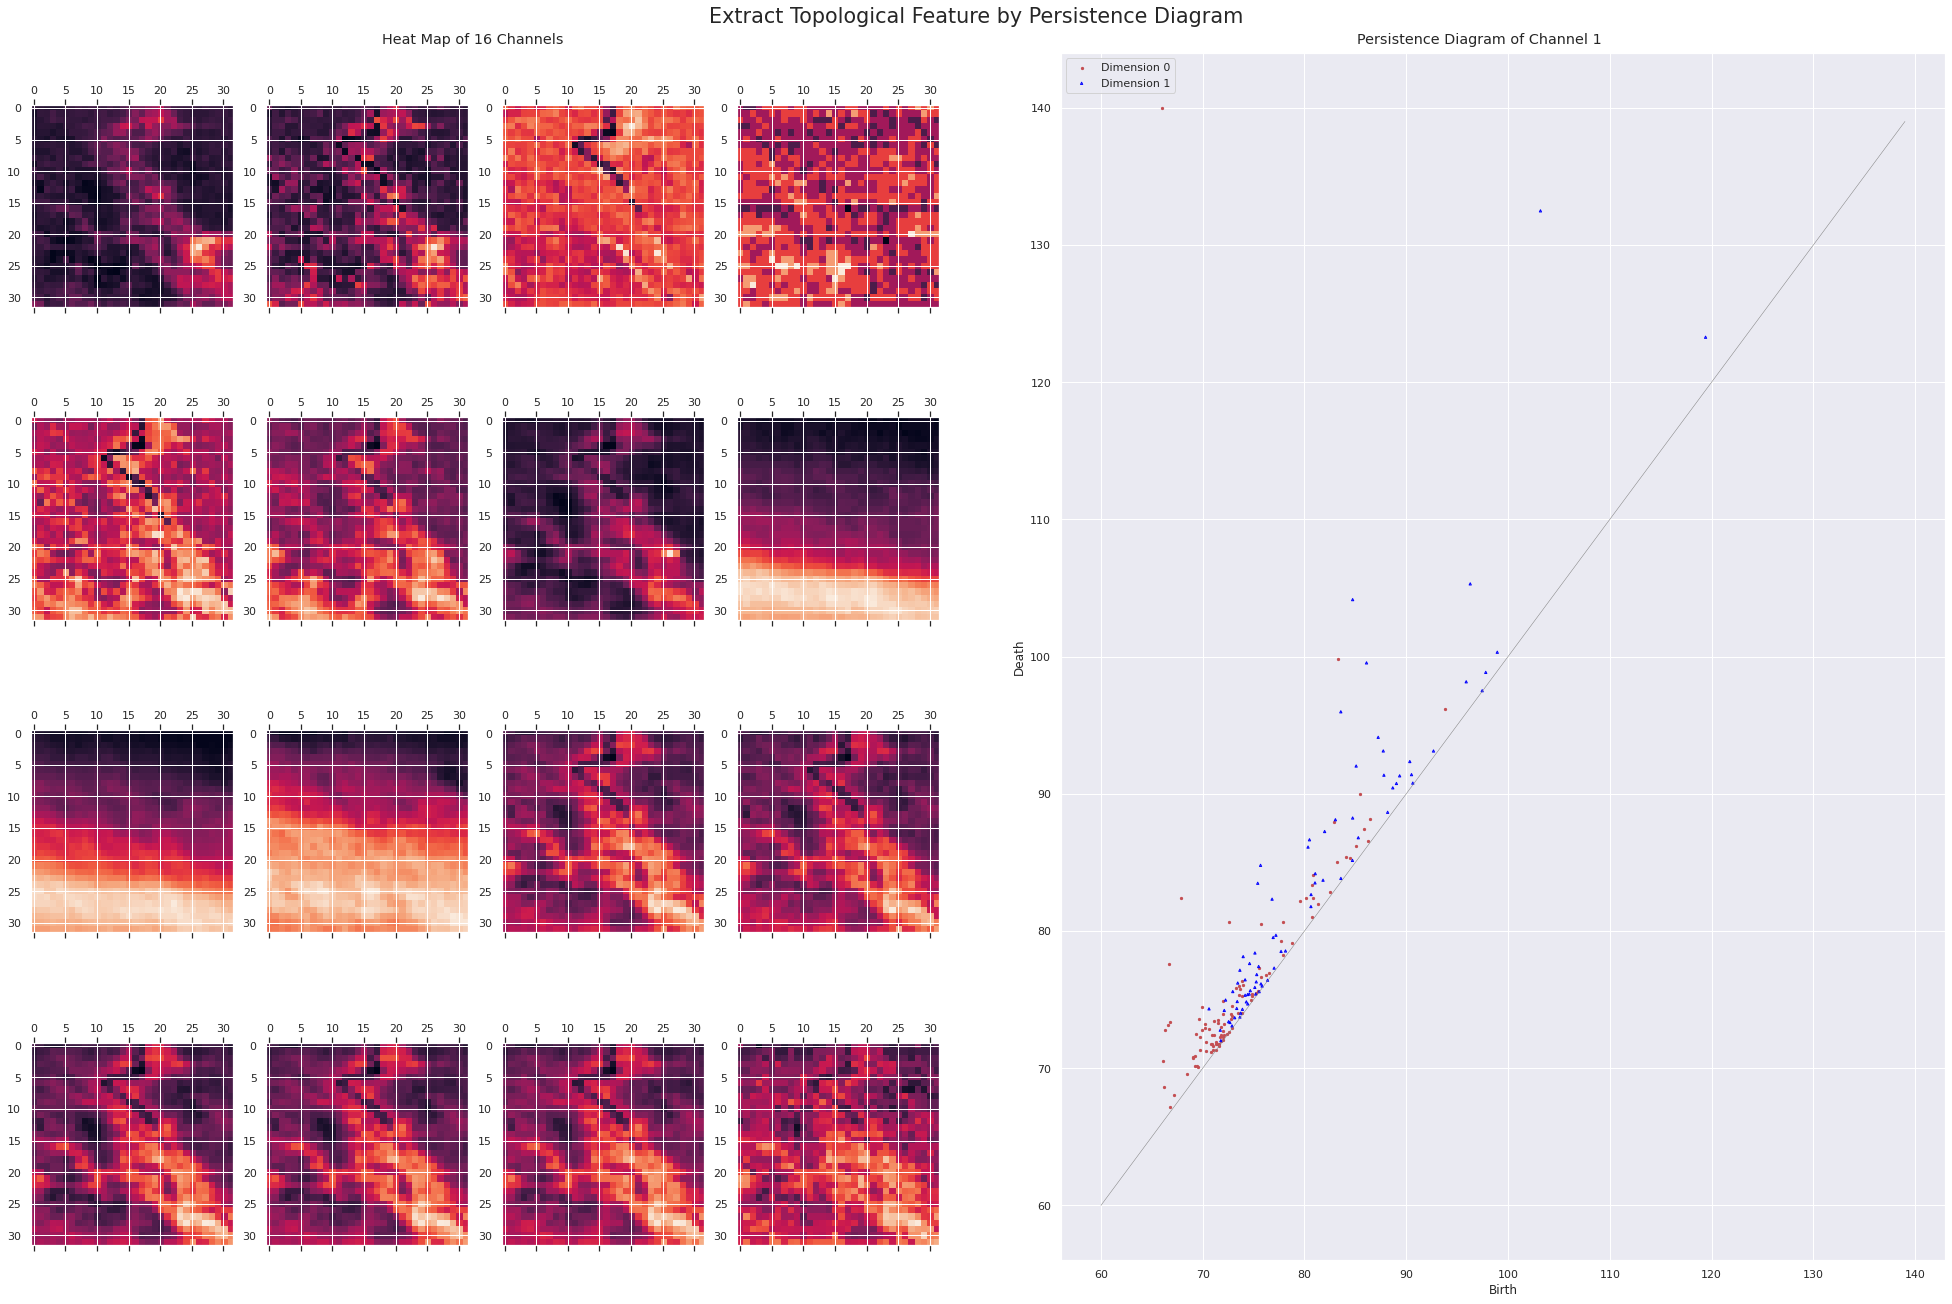

In [21]:
fname2 = 'Sample Data'

fig = plt.figure(constrained_layout=True, figsize=(27, 18))
subfigs = fig.subfigures(1, 2, wspace=0.07)

for channelNum in np.arange(16):
    ax = subfigs[0].add_subplot(4,4,1+channelNum)
    tileNum = np.array(zarr.open(fname2 + '//' + 'Tile_1_33.zarr')[:, :, channelNum])
    ax.matshow(tileNum)
subfigs[0].suptitle('Heat Map of 16 Channels')

axsRight = subfigs[1].subplots(1, 1)
sampleData = np.array(zarr.open(fname2 + '//' + 'Tile_1_33.zarr')[:, :, 0])
f_lower_star = d.fill_freudenthal(sampleData)
p = d.homology_persistence(f_lower_star)
dgms = d.init_diagrams(p, f_lower_star)

# These two values changes on different channel since different channel have different value distributions.
lower_bound = 60 
upper_bound = 140

birth0=np.array([dgm.birth for dgm in dgms[0]])
death0=np.array([dgm.death for dgm in dgms[0]])
death0[death0==np.Infinity] = upper_bound
birth1=np.array([dgm.birth for dgm in dgms[1]])
death1=np.array([dgm.death for dgm in dgms[1]])
death1[death1==np.Infinity] = upper_bound

axsRight.scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
axsRight.scatter(birth1, death1, marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
axsRight.legend(loc="upper left")

axsRight.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
#axsRight.xlim([lower_bound, upper_bound])
#axsRight.ylim([lower_bound, upper_bound])
axsRight.set_xlabel('Birth')
axsRight.set_ylabel('Death')

subfigs[1].suptitle('Persistence Diagram of Channel 1')

fig.suptitle('Extract Topological Feature by Persistence Diagram', fontsize='xx-large')
plt.show()

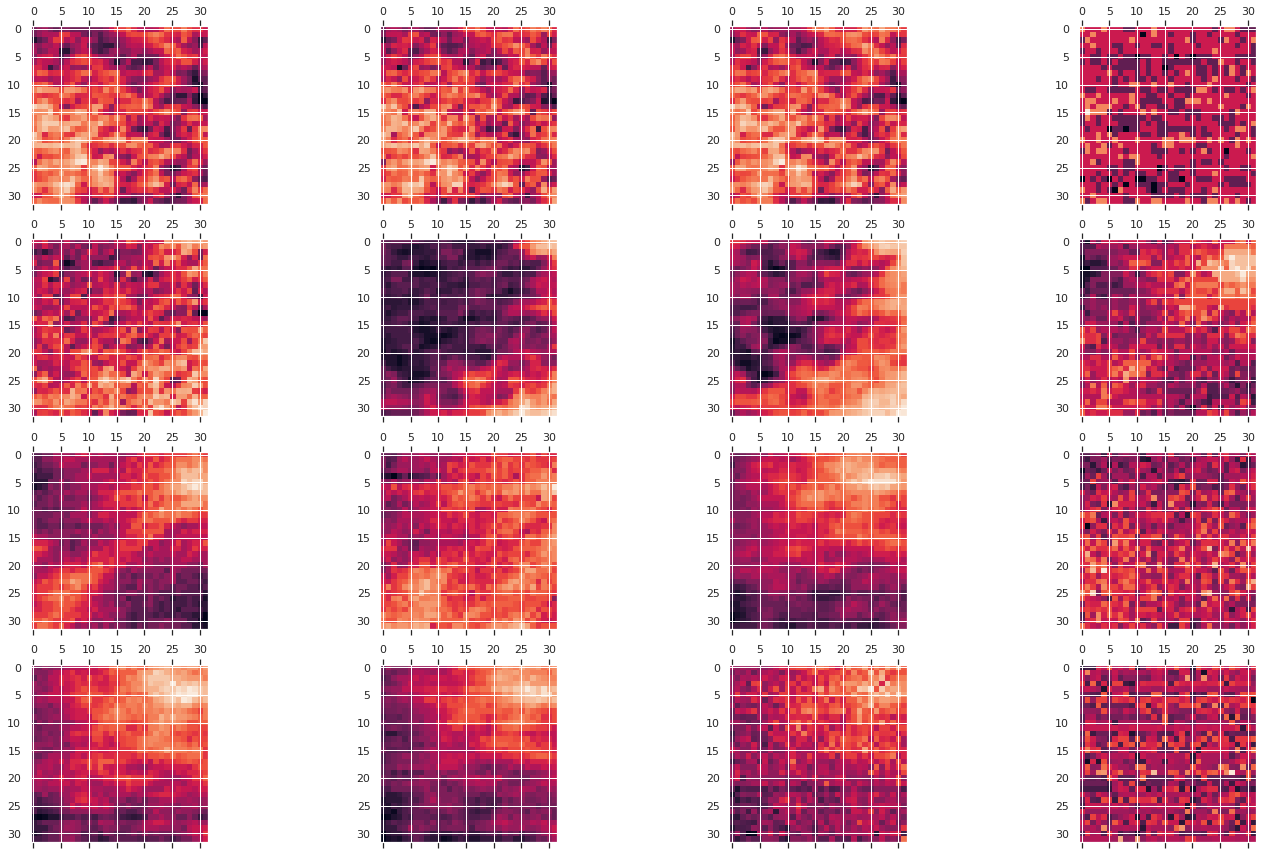

In [ ]:
fname2 = 'Sample Data'

fig= plt.figure(figsize=(24,15))

for channelNum in np.arange(16):
    ax = fig.add_subplot(4,4,1+channelNum)
    tileNum = np.array(zarr.open(fname2 + '//' + 'Tile_0_0.zarr')[:, :, channelNum])
    ax.matshow(tileNum)

plt.show()

Text(0.5, 1.0, 'Persistent Diagram of Channel 1')

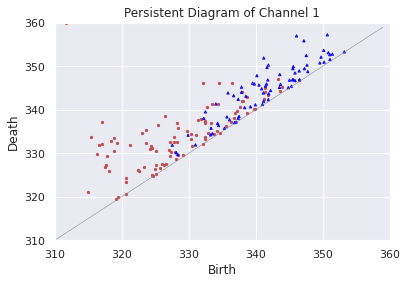

In [ ]:
sampleData = np.array(zarr.open(fname2 + '//' + 'Tile_0_0.zarr')[:, :, 0])
f_lower_star = d.fill_freudenthal(sampleData)
p = d.homology_persistence(f_lower_star)
dgms = d.init_diagrams(p, f_lower_star)

birth0=np.array([dgm.birth for dgm in dgms[0]])
death0=np.array([dgm.death for dgm in dgms[0]])
death0[death0==np.Infinity] = 360
birth1=np.array([dgm.birth for dgm in dgms[1]])
death1=np.array([dgm.death for dgm in dgms[1]])
death1[death1==np.Infinity] = 360

plt.scatter(birth0, death0, color='r', s=5, label = '0')
plt.scatter(birth1, death1, marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')
lower_bound = 310
upper_bound = 360
plt.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
plt.xlim([lower_bound, upper_bound])
plt.ylim([lower_bound, upper_bound])
plt.xlabel('Birth')
plt.ylabel('Death')
plt.title('Persistent Diagram of Channel 1')


1114


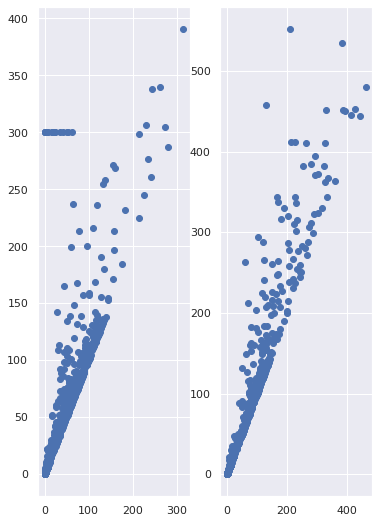

In [ ]:
fname2 = 'Sample Data'
a, b = getAllChannelPDs('Tile_5_37.zarr', 16)
print (len(a))

fig = plt.figure(figsize = (6, 9))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(a[:, 0], a[:, 1])
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(b[:, 0], b[:, 1])
plt.show()

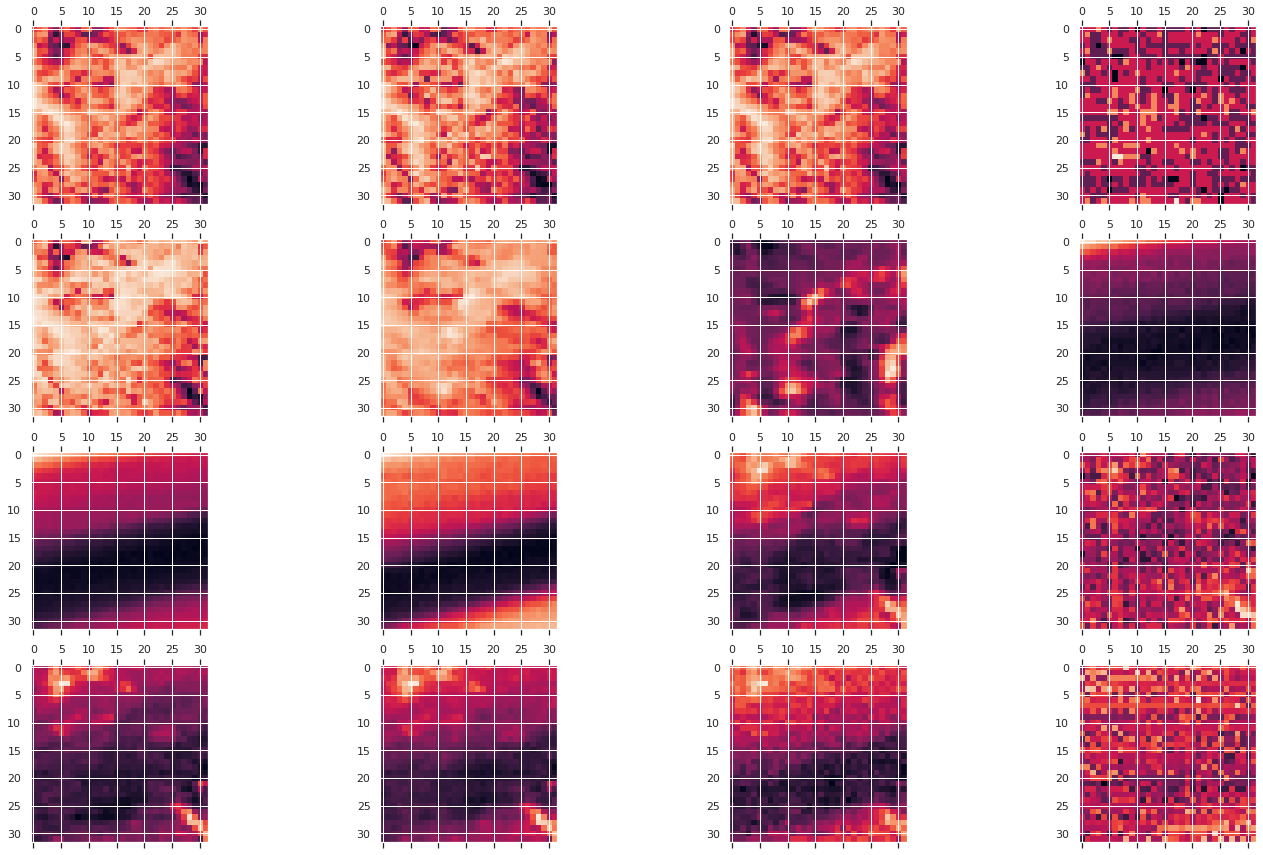

In [ ]:
'''
f = netCDF4.Dataset('MERRA2_t2m_CONUS_20210201-20210228_hp05.nc', 'r')
print(f)
'''
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
fname2 = 'Sample Data'

#ds = xr.open_dataset(fname)
#data = ds['t2m'].squeeze()

#lon = ds.lon
#lat = ds.lat

# data2 = zarr.open(fname2 + '//' +'Tile_0_0.zarr')[:, :, 0]
#data = selectChannel(fname2, channelNum)
#print (np.shape(data))

#tile0_0 = np.array(zarr.open(fname2 + '//' + 'Tile_0_0.zarr')[:, :, 5])
#plt.matshow(tile0_0)
# print (tile0_0)

fig= plt.figure(figsize=(24,15))
for channelNum in np.arange(16):
    ax = fig.add_subplot(4,4,1+channelNum)
    tileNum = np.array(zarr.open(fname2 + '//' + 'Tile_0_21.zarr')[:, :, channelNum])
    ax.matshow(tileNum)

plt.show()


In [ ]:
def getAllChannelPDs(tileName, channelRange, infinity = 300):
    PD0 = np.array([[0, 0]])
    PD1 = np.array([[0, 0]])
    for i in range(channelRange):
        data = np.array(zarr.open(fname2 + '//' + tileName)[:, :, i])
        f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
        p = d.homology_persistence(f_lower_star)
        dgms = d.init_diagrams(p, f_lower_star)
        birth0=np.array([dgm.birth for dgm in dgms[0]])
        death0=np.array([dgm.death for dgm in dgms[0]])
        death0[death0==np.Infinity] = infinity 
        birth1=np.array([dgm.birth for dgm in dgms[1]])
        death1=np.array([dgm.death for dgm in dgms[1]])
        death1[death1==np.Infinity] = infinity
        
        temp0 = np.vstack((birth0, death0)).T
        temp1 = np.vstack((birth1, death1)).T

        PD0 = np.concatenate((PD0, temp0))
        PD1 = np.concatenate((PD1, temp1))
        
    return PD0[1:, :], PD1[1:, :]

In [ ]:
def channel2Mat(tile):
    channelLength = np.shape(zarr.open(fname2 + '//' + tile)[0, 0, :])[0]

    bd = np.zeros((channelLength, 10000))
    for i in range(channelLength):
        data = np.array(zarr.open(fname2 + '//' + tile)[:, :, i])
        f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
        p = d.homology_persistence(f_lower_star)
        dgms = d.init_diagrams(p, f_lower_star)
        birth0=np.array([dgm.birth for dgm in dgms[0]])
        death0=np.array([dgm.death for dgm in dgms[0]])
        death0[death0==np.Infinity] = np.partition(death0.flatten(), -2)[-2]
        birth1=np.array([dgm.birth for dgm in dgms[1]])
        death1=np.array([dgm.death for dgm in dgms[1]])
        death1[death1==np.Infinity] = np.partition(death1.flatten(), -2)[-2]
        temp0 = np.vstack((birth0, death0)).T
        temp1 = np.vstack((birth1, death1)).T
        temp = np.concatenate((temp0, temp1))
        # normalize the vector
        bdTemp = temp[:, 1] - temp[:, 0]
        bdTemp = (bdTemp - np.min(bdTemp)) / (np.max(bdTemp) - np.min(bdTemp))
        loc, scale = expon.fit(bdTemp)
        bdSample = np.random.exponential(scale=scale, size = 10000)
        bd[i, :] = bdSample
    
    corrMat = np.corrcoef(bd)
    return corrMat


In [ ]:
def fNorm(mat):
    singularValues = scipy.linalg.svdvals(mat)
    L2norm = np.linalg.norm(singularValues, ord=2)
    return L2norm

In [ ]:
tileList = ['Tile_0_0.zarr', 'Tile_1_10.zarr', 'Tile_4_5.zarr', 'Tile_6_15.zarr', 'Tile_1_33.zarr', 'Tile_2_35.zarr', 'Tile_3_33.zarr', 'Tile_5_37.zarr', 'Tile_13_37.zarr']

fname2 = 'Sample Data'
print (np.shape(channel2Mat('Tile_0_0.zarr')))

corrMat = []
for tile in tileList:
    corrMat.append(channel2Mat(tile))

disMat = np.zeros((len(tileList), len(tileList)))
for i in range(len(tileList)):
    for j in range(i+1, len(tileList)):
        disMat[i, j] = np.abs(fNorm(corrMat[i]) - fNorm(corrMat[j]))
        disMat[j, i] = disMat[i, j]

print (disMat)

In [ ]:
results = {}
results['pds']= {}
params = {}
params['pds']= {}
clusters = {}
clusters['pds']= {}

In [ ]:
results['DBSCAN'] = {}
params['DBSCAN'] = {}
clusters['DBSCAN'] = {}

In [ ]:
eps={'min':0.01, 'max':10, 'inc': 0.005}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['DBSCAN'][score] = {}
    params['DBSCAN'][score] = {}
    clusters['DBSCAN'][score] = {}
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=disMat, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    results['DBSCAN'][score]= score_
    params['DBSCAN'][score]['eps'] = eps_
    params['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['DBSCAN'][score] = clusters_

In [ ]:
for key in clusters['DBSCAN'].keys():
    
    print (clusters['DBSCAN'][key].labels_)

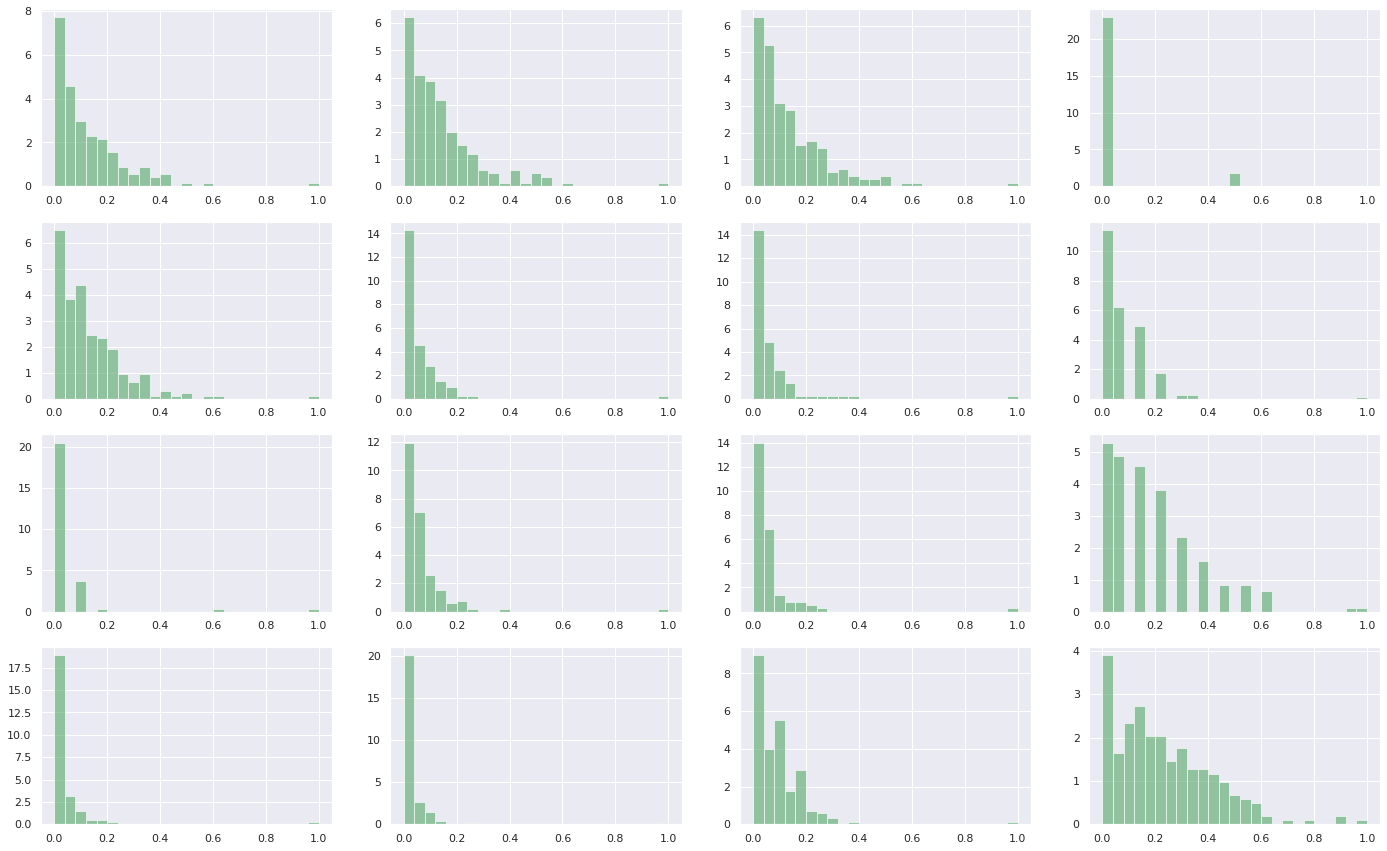

In [ ]:
channelLength = np.shape(zarr.open(fname2 + '//' + 'Tile_0_0.zarr')[0, 0, :])[0]
fname2 = 'Sample Data'


bd = []
for i in range(channelLength):
    data = np.array(zarr.open(fname2 + '//' + 'Tile_0_0.zarr')[:, :, i])
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = np.partition(death0.flatten(), -2)[-2]
    birth1=np.array([dgm.birth for dgm in dgms[1]]) # We can try only using dim1 features
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = np.partition(death1.flatten(), -2)[-2]
    temp0 = np.vstack((birth0, death0)).T
    temp1 = np.vstack((birth1, death1)).T
    temp = np.concatenate((temp0, temp1))
    # normalize the vector
    bdTemp = temp[:, 1] - temp[:, 0]
    bdTemp = (bdTemp - np.min(bdTemp)) / (np.max(bdTemp) - np.min(bdTemp))
    bd.append(bdTemp)

#plt.hist(bd[3], bins=25, density=True, alpha=0.6, color='g')
#plt.show()

fig= plt.figure(figsize=(24,15))
for channelNum in np.arange(16):
    ax = fig.add_subplot(4,4,1+channelNum)
    plt.hist(bd[channelNum], bins=25, density=True, alpha=0.6, color='g')

plt.show()


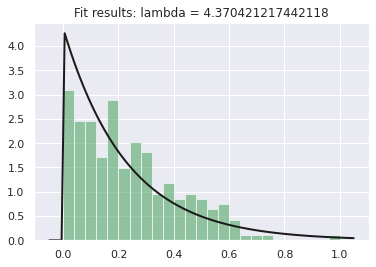

In [ ]:
from scipy.stats import expon

# Fit a normal distribution to the data:
data = bd[15]
loc, scale = expon.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: lambda = {}".format(1/scale)
plt.title(title)

plt.show()